In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
# rng = np.random.default_rng()

@njit
def run(lat_dim, N):
    # lat_dim = 150
    lattice = np.zeros((lat_dim, lat_dim), dtype=np.int32)
    
    # Seed one particle at the center
    center = lat_dim // 2
    lattice[center, center] = 1
    
    # N = 10000  # Number of particles
    count_N = []
    R_max_vals = []
    step_counts_killed = []
    step_counts_agg = []
    d = 2
    for _ in range(N):
        # Get existing particle positions
        particles_x, particles_y = np.where(lattice)
        particles_x -= center
        particles_y -= center
        p_distances = np.hypot(particles_x, particles_y)
        
        R_max = np.max(p_distances)
        count_N.append(np.sum(lattice))
        R_max_vals.append(int(R_max))
    
        R_start = R_max + d
        R_kill = center - 5
        R_d = R_start + 20
    
        if R_start >= R_kill:
            break  # Stop if the radius is too large
    
        # Generate random starting position
        angle_random = np.random.uniform(0, 2 * np.pi)
        radius_random = np.random.randint(int(R_start), int(R_kill))
        x_pos = int(radius_random * np.cos(angle_random) + center)
        y_pos = int(radius_random * np.sin(angle_random) + center)
    
        # Random walk
        moves = np.array([[0, 1], [0, -1], [-1, 0], [1, 0]])  # Up, Down, Left, Right
        walking = True
        step_counter = 0
        while walking:
            # Adjust step size based on distance
            current_radius = (x_pos - center) ** 2 + (y_pos - center) ** 2
            current_radius = np.sqrt(current_radius)
            R_walk = 10 if current_radius > R_d else 1
    
            # Random move
            move = moves[np.random.randint(0, 4)] * R_walk
            x_pos = max(0, min(x_pos + move[0], lat_dim - 1))
            y_pos = max(0, min(y_pos + move[1], lat_dim - 1))
            step_counter += 1
            # Check if next position is occupied
            current_radius = (x_pos - center) ** 2 + (y_pos - center) ** 2
            current_radius = np.sqrt(current_radius)
            if lattice[y_pos, x_pos] == 1:
                lattice[y_pos - move[1], x_pos - move[0]] = 1
                walking = False
                step_counts_agg.append(step_counter)
    
            # If particle escapes
            elif current_radius > R_kill:
                walking = False
                step_counts_killed.append(step_counter)
    
    # Plot result
    return lattice, count_N, R_max_vals, step_counts_killed, step_counts_agg
lattice, count_N, R_max_vals, step_counts_killed, step_counts_agg = run(500, 100000)

/home/aegis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<Figure size 720x720 with 0 Axes>

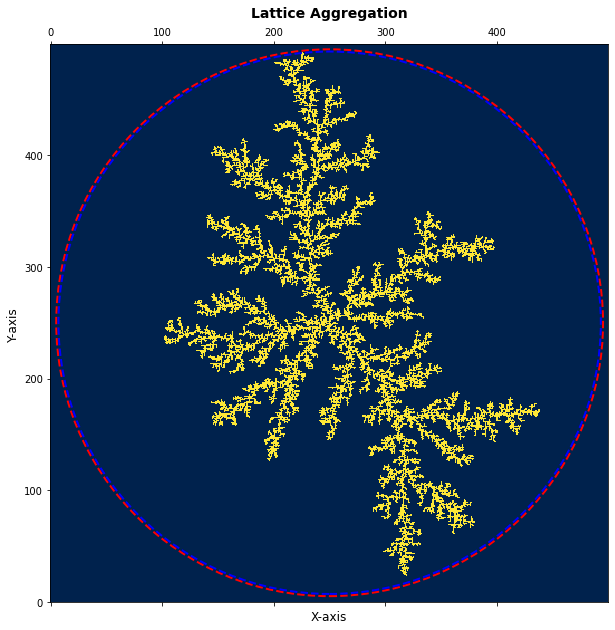

In [2]:
#PLOT
import matplotlib.patches as patches
R_kill = center = 500 // 2 - 5
R_max = R_max_vals[-1]
plt.figure(figsize=(10, 10)) 
plt.matshow(lattice, origin="lower", cmap="cividis")
circle_kill = patches.Circle((lattice.shape[1] // 2, lattice.shape[0] // 2), R_kill, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
circle_max = patches.Circle((lattice.shape[1] // 2, lattice.shape[0] // 2), R_max, linewidth=2, edgecolor='blue', facecolor='none', linestyle='--')
plt.gca().add_patch(circle_kill)
plt.gca().add_patch(circle_max)
# plt.colorbar(label="Occupied Cells")
plt.title("Lattice Aggregation", fontsize=14, fontweight="bold", pad=10)
plt.xlabel("X-axis", fontsize=12)
plt.ylabel("Y-axis", fontsize=12)
plt.gcf().set_size_inches(10, 10)
plt.savefig("lattice_aggregation.pdf", format="pdf")
plt.show()

In [3]:
print(max(count_N))
np_arr_N = np.array(count_N)
np_arr_R = np.array(R_max_vals)
np_arr_Steps_a = np.array(step_counts_agg)
np_arr_Steps_k = np.array(step_counts_killed)
#Clean Remove indices where R_max = 0 and 1
indices = np.where((np_arr_R == 0) | (np_arr_R == 1))[0]
print(indices)
np_arr_R_filtered = np.delete(np_arr_R, indices)
np_arr_N_filtered = np.delete(np_arr_N, indices)

D = np.log(np_arr_N_filtered)/np.log(np_arr_R_filtered)

18450
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


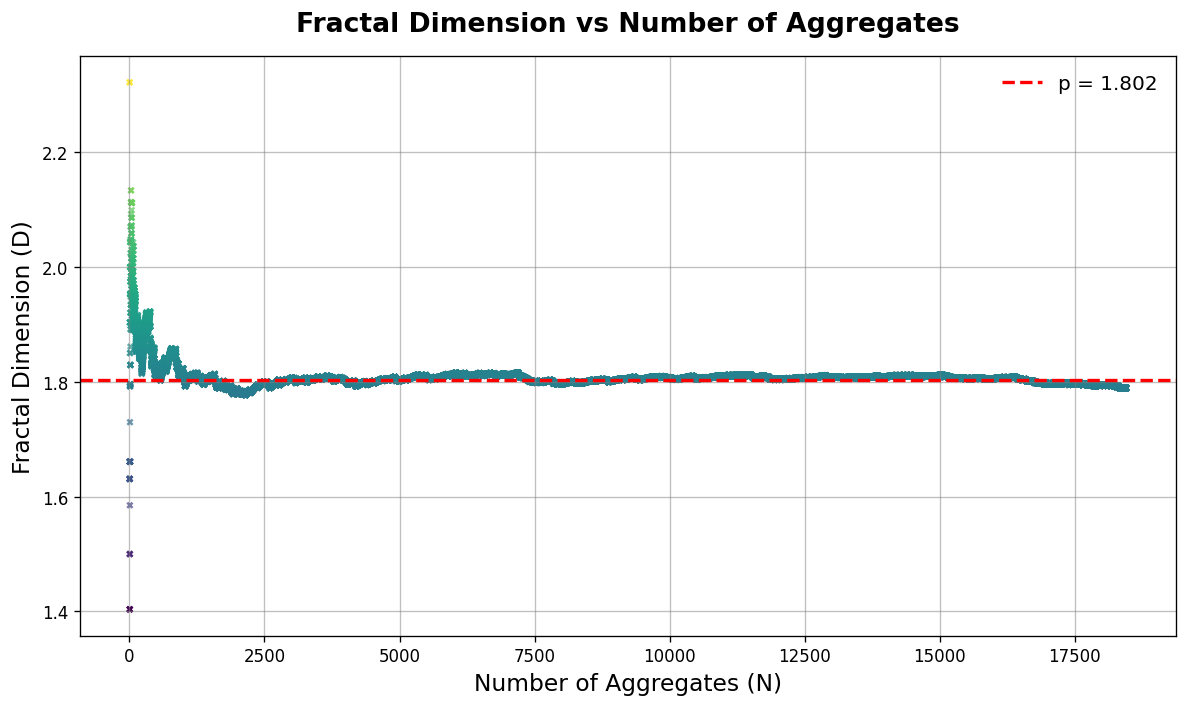

In [13]:
p = np.mean(D[7000:])

plt.figure(figsize=(10, 6), dpi=120)
plt.scatter(np_arr_N_filtered, D, c=D, cmap='viridis', s=10, alpha=0.7, marker = 'x')  # Use a colormap
plt.axhline(p, linestyle="--", color='red', label=f"p = {p:.3f}", linewidth=2)
plt.title("Fractal Dimension vs Number of Aggregates", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Number of Aggregates (N)", fontsize=14)
plt.ylabel("Fractal Dimension (D)", fontsize=14)
plt.grid(True, linestyle='-', color='gray', alpha=0.5)
plt.legend(fontsize=12, loc='best', frameon=False)
plt.tight_layout()
plt.savefig("DvN.pdf", format="pdf", bbox_inches="tight")
plt.show()

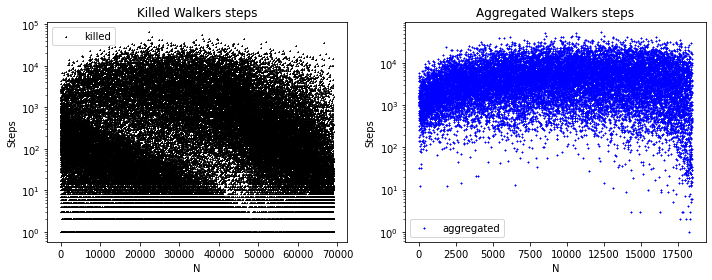

In [5]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(np.arange(len(np_arr_Steps_k)),np_arr_Steps_k, color='k', marker = '+', label='killed', s = 1)
axes[0].set_yscale('log')
axes[0].set_title('Killed Walkers steps')
axes[0].set_xlabel('N')
axes[0].set_ylabel('Steps')
axes[0].legend()
axes[1].scatter(np.arange(len(np_arr_Steps_a)),np_arr_Steps_a, color='b', marker = 'x', label='aggregated', s = 1)
axes[1].set_yscale('log')
axes[1].set_title('Aggregated Walkers steps')
axes[1].set_xlabel('N')
axes[1].set_ylabel('Steps')
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.savefig("StepsvN.pdf", format="pdf", bbox_inches="tight")
plt.show()

(array([1.2219e+04, 3.9610e+03, 1.3660e+03, 5.4700e+02, 2.1200e+02,
        8.2000e+01, 3.8000e+01, 1.7000e+01, 4.0000e+00, 3.0000e+00]),
 array([1.00000e+00, 5.35540e+03, 1.07098e+04, 1.60642e+04, 2.14186e+04,
        2.67730e+04, 3.21274e+04, 3.74818e+04, 4.28362e+04, 4.81906e+04,
        5.35450e+04]),
 <BarContainer object of 10 artists>)

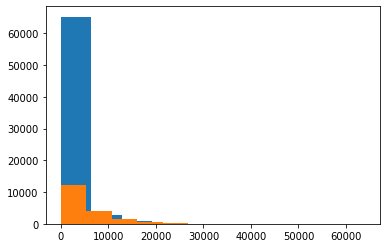

In [9]:
plt.hist(np_arr_Steps_k)
plt.hist(np_arr_Steps_a)
# plt.semilogy()